# NLP Project

- In this project, we analyze user reviews from the top five social media apps—TikTok, Facebook, Instagram, YouTube, and WhatsApp—across four countries: the United States (US), France (FR), Canada (CA), and Australia (AU). Our goal is to predict star ratings based on the textual content of these reviews and extract meaningful insights into user sentiment.
- We began by preprocessing the text data through tokenization, lemmatization, and conversion to lowercase to ensure consistency and prepare the data for modeling. We initially employed linear predictive models, including Logistic Regression and LinearSVC, to classify the reviews. However, these models faced challenges due to the imbalanced nature of the dataset, particularly with neutral ratings (class 3), which comprised only 858 out of 10,000 entries. This imbalance led to low precision, recall, and F1 scores for the neutral category.
- To further explore the underlying structure of the reviews, we applied K-means clustering, grouping the reviews into five categories. This clustering provided additional insights into the data and helped refine our understanding of user feedback.

### Imports 

In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

### Scrape App reviews

In [2]:
def fetch_reviews(app_id, country_code, page_number):
    url = f"https://itunes.apple.com/{country_code}/rss/customerreviews/id={app_id}/page={page_number}/sortby=mostrecent/json"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        return None     

def extract_reviews(data):
    reviews = []
    if 'feed' in data and 'entry' in data['feed']:
        for entry in data['feed']['entry']:
            if 'content' in entry and 'im:rating' in entry:
                review = {
                    'review': entry['content']['label'],
                    'rating': int(entry['im:rating']['label'])
                }
                reviews.append(review)
    return reviews

In [3]:
# Fetching reviews for social media apps in 4 different regions
app_ids = {'TikTok': '835599320', 'Facebook': '284882215', 'Instagram': '389801252', 'Youtube': '544007664', 'WhatsApp':'310633997'}
country_codes = {'USA':'us', 'France':'fr', 'Canada':'ca', 'Australia':'au'}
page = 10

# Initialize reviews list
all_reviews = []

# Loop over each app name, country name and number of pages
for app_name, app_id in app_ids.items():
    for country_name, country_code in country_codes.items():
        for page in range(1, page + 1):
            
            # Fetch reviews for current app and country 
            data = fetch_reviews(app_id, country_code, page)
            if data:
                reviews = extract_reviews(data)
                # Add app name and country code 
                for review in reviews:
                    review['app_name'] = app_name
                    review['country_code'] = country_code
                #Append each review into the list    
                all_reviews.extend(reviews)

# Convert the list of reviews to a DataFrame
df = pd.DataFrame(all_reviews)
# Reorder the columns
df = df[['app_name', 'country_code', 'rating', 'review']]

df.head()

,app_name,country_code,rating,review
0,TikTok,us,5,محتوا جميل
1,TikTok,us,5,I love Ticktock !
2,TikTok,us,1,Esli is on that platform n I don’t like her
3,TikTok,us,5,Entertaining and useful.
4,TikTok,us,5,Me encantaaa 😻🥰


### Data Visualization 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9950 entries, 0 to 9949
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   app_name      9950 non-null   object
 1   country_code  9950 non-null   object
 2   rating        9950 non-null   int64 
 3   review        9950 non-null   object
dtypes: int64(1), object(3)
memory usage: 311.1+ KB


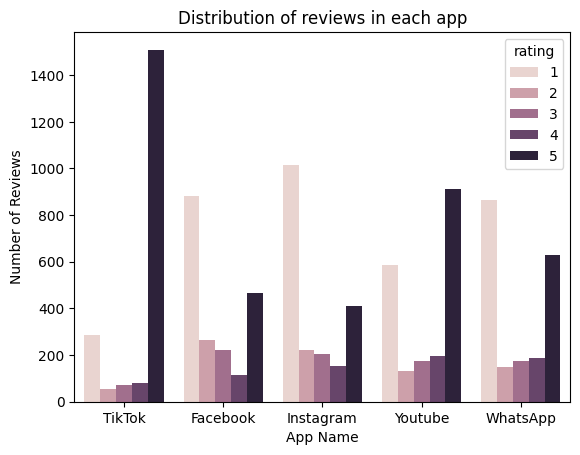

In [5]:
# Distribution of reviews in each app
sns.countplot(data=df, x='app_name', hue='rating')

plt.title('Distribution of reviews in each app')
plt.xlabel('App Name')
plt.ylabel('Number of Reviews')
plt.show()

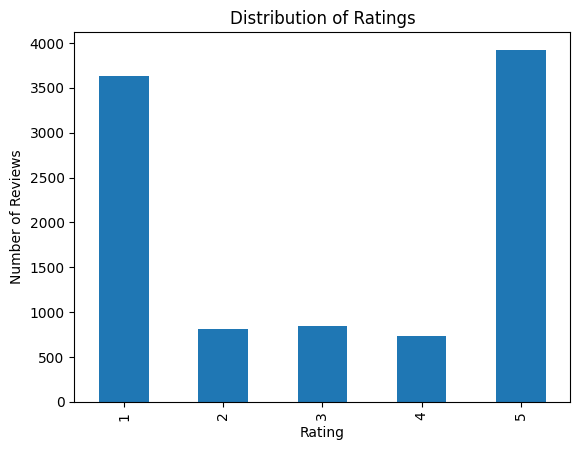

In [6]:
# Distribution of ratings by rank
df['rating'].value_counts().sort_index().plot(kind='bar')

plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

In [7]:
df['rating'].value_counts()

rating
5    3923
1    3628
3     845
2     817
4     737
Name: count, dtype: int64

- There is a noticeable skew towards the extremes, with the majority of reviews being either rating 5 or rating 1.
- The intermediate ratings (2, 3, and 4 stars) are significantly less common.

In [8]:
# Classify the rating into sentiment labels
df['sentiment_label'] = df['rating'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))

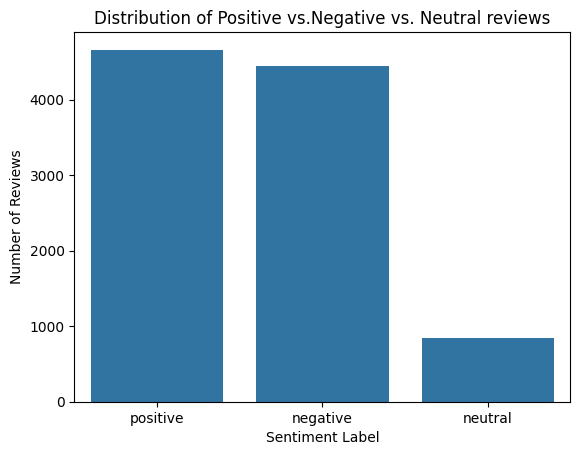

In [9]:
# Distribution of sentiment labels
sns.countplot(data=df, x='sentiment_label')

plt.title('Distribution of Positive vs.Negative vs. Neutral reviews')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Reviews')
plt.show()

### Text Preprocessing 

In [10]:
import string

In [11]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [12]:
import nltk
nltk.download('punkt_tab')       # For tokenization
nltk.download('wordnet')         # For lemmatization
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to C:\Users\Michael
[nltk_data]     2023\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Michael
[nltk_data]     2023\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Michael
[nltk_data]     2023\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    punctuationfree=''.join([i for i in text if i not in string.punctuation])
    lowercased = punctuationfree.lower() 
    tokens = word_tokenize(lowercased)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    # Join tokens back into a single string
    cleaned_text = ' '.join(lemmatized)
    return cleaned_text

df['clean_review'] = df['review'].apply(clean_text)
df['clean_review'].head()

0                                       محتوا جميل
1                                  i love ticktock
2    esli is on that platform n i don ’ t like her
3                          entertaining and useful
4                                  me encantaaa 😻🥰
Name: clean_review, dtype: object

### Logistic Regression

In [14]:
# Separate X feature and target y
X = df['clean_review']
y = df['sentiment_label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Text Vectorization
# Apply TfidfVectorizer to obtain TF-IDF matrix

tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# LogistcRegression model
log_model = LogisticRegression()
log_model.fit(X_train_tfidf,y_train)

# LogisticRegression model performance
log_preds=log_model.predict(X_test_tfidf)

print(classification_report(y_test, log_preds))

              precision    recall  f1-score   support

    negative       0.73      0.82      0.77       886
     neutral       0.50      0.01      0.01       176
    positive       0.78      0.84      0.81       928

    accuracy                           0.76      1990
   macro avg       0.67      0.56      0.53      1990
weighted avg       0.74      0.76      0.72      1990



### LinearSVC Model

In [15]:
# Trains a linear support vector classifier (SVC) model on the TF-IDF-transformed training data.

svc_model = LinearSVC()
svc_model.fit(X_train_tfidf, y_train)

svc_preds=svc_model.predict(X_test_tfidf)
print(classification_report(y_test, svc_preds))

              precision    recall  f1-score   support

    negative       0.73      0.78      0.75       886
     neutral       0.14      0.02      0.03       176
    positive       0.76      0.84      0.80       928

    accuracy                           0.74      1990
   macro avg       0.54      0.54      0.53      1990
weighted avg       0.69      0.74      0.71      1990



- The dataset is highly imbalanced since rating 3 reviews only have 858 out of 10,000 entries, then class neutral has very low rate on precision, recall, and f1-score

### K-means

In [16]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_kmeans = vectorizer.fit_transform(df['clean_review']).toarray()

from sklearn.decomposition import PCA
# Reduce the dimensionality of the data into 3 components

pca = PCA(n_components=3) 
X_reduced = pca.fit_transform(X_kmeans)

In [17]:
# Imports
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, n_init=10, algorithm='elkan') 
df['cluster'] = kmeans.fit_predict(X_reduced)

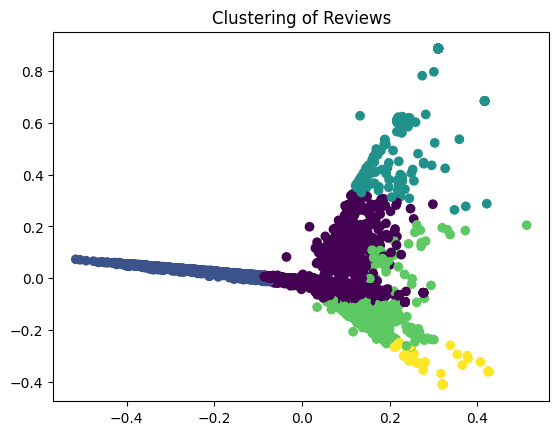

In [18]:
# Scatterplot of clustering in 2d
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df['cluster'], cmap='viridis')
plt.title('Clustering of Reviews')
plt.show()

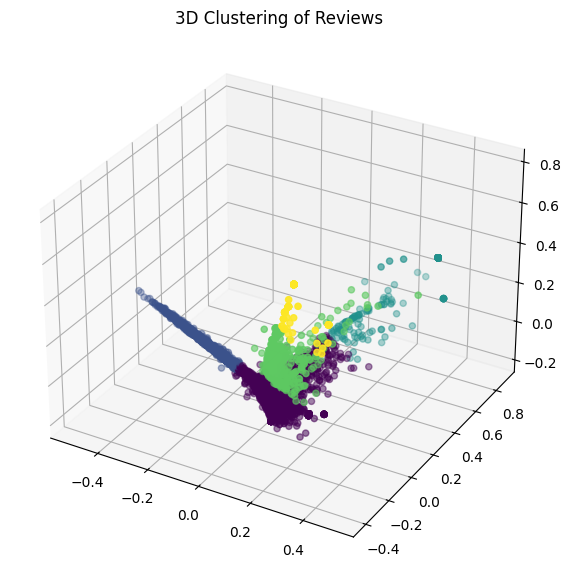

In [19]:
# Clustering in 3d
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=df['cluster'], cmap='viridis')
ax.set_title('3D Clustering of Reviews')
plt.show()

### Interpretation of each cluster

In [20]:
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer


# Step 1: Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X_text = vectorizer.fit_transform(df['clean_review'])

# Step 2: For each cluster, get the top 10 most common words
top_words_per_cluster = {}

for cluster_num in np.unique(df['cluster']):
    # Filter reviews in the current cluster
    cluster_reviews = df[df['cluster'] == cluster_num]['clean_review']
    
    # Vectorize the reviews in the current cluster
    cluster_matrix = vectorizer.transform(cluster_reviews)
    
    # Sum up the occurrences of each word in the cluster
    word_counts = np.sum(cluster_matrix, axis=0)
    
    # Get the words corresponding to the indices
    word_freq = [(word, word_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    
    # Sort words by frequency and get the top 10
    top_words = sorted(word_freq, key=lambda x: x[1], reverse=True)[:10]
    
    # Store the top words in the dictionary
    top_words_per_cluster[cluster_num] = top_words

# Step 3: Display the top 10 words for each cluster
for cluster_num, top_words in top_words_per_cluster.items():
    print(f"Cluster {cluster_num}:")
    for word, freq in top_words:
        print(f"{word}: {freq}")
    print("\n")

Cluster 0:
app: 1960
ad: 1308
account: 1041
like: 1010
video: 964
just: 860
people: 835
wa: 811
post: 796
time: 775


Cluster 1:
le: 1874
je: 1366
et: 1324
est: 1175
que: 968
pa: 936
la: 922
ne: 697
pour: 669
en: 656


Cluster 2:
good: 211
app: 26
youtube: 8
tiktok: 7
really: 7
work: 7
video: 6
watch: 6
like: 5
use: 5


Cluster 3:
love: 466
app: 145
youtube: 115
tiktok: 78
like: 71
video: 65
people: 50
good: 45
great: 42
just: 41


Cluster 4:
love: 134
app: 17
youtube: 15
tiktok: 10
just: 4
watch: 4
video: 3
best: 3
instagram: 3
amazing: 2




#### Cluster 0:
- Top Words: "app", "ad", "account", "like", "video", "just", "people"
- Interpretation: This cluster seems to include reviews that focus on more critical aspects of the apps. Words like "ad," "account," and "just" suggest that users might be discussing issues related to advertisements, account management, or specific frustrations (e.g., "just" as in "just fix this" or "just want"). This cluster likely represents a mix of neutral to negative reviews, where users are discussing problems or annoyances they encounter.  
#### Cluster 1:
- Top Words: "le", "je", "et", "est", "que", "la"
- Interpretation: This cluster seems to be dominated by reviews written in French. The common words here are French stopwords, which are frequent in French-language text. This cluster likely represents reviews from French-speaking users, possibly focusing on various aspects of the apps, but further context is needed to determine the sentiment.
#### Cluster 2:
- Top Words: "love", "app", "youtube", "tiktok", "just"
- Interpretation: The repetition of "love" suggests that users in this cluster are also expressing high satisfaction, but with less emphasis on specific features or aspects of the apps. The cluster could represent a subset of users who are very satisfied but provide more concise feedback.
#### Cluster 3:
- Top Words: "love", "app", "youtube", "tiktok", "like", "video"
- Interpretation: This cluster likely consists of positive reviews where users express strong affection or satisfaction with the apps, particularly with YouTube and TikTok. The presence of words like "love," "good," and "great" indicates high user satisfaction and possibly recommendations.
#### Cluster 4:
- Top Words: "good", "app", "tiktok", "youtube", "really", "work"
- Interpretation: This cluster seems to represent reviews that are generally positive but less enthusiastic than those in Cluster 0. Users mention that the apps are "good" and "work," indicating satisfaction with functionality, particularly with TikTok and YouTube. The reviews might focus on the usability or performance of the apps. 

3 out of the 5 clusters have very similar interpretations. Clusters 3,4 and 5 have a positive sentiment and in terms of word frequency, they have some overlapping words for example app, tik tok, youtube and love. Ultimately, we could group these clusters as one. As for cluster 1, we could remove all languages other then english to improve model performance.

### Sentiment Analysis

In [23]:
df

,app_name,country_code,rating,review,sentiment_label,clean_review,cluster
0,TikTok,us,5,محتوا جميل,positive,محتوا جميل,0
1,TikTok,us,5,I love Ticktock !,positive,i love ticktock,3
2,TikTok,us,1,Esli is on that platform n I don’t like her,negative,esli is on that platform n i don ’ t like her,0
3,TikTok,us,5,Entertaining and useful.,positive,entertaining and useful,0
4,TikTok,us,5,Me encantaaa 😻🥰,positive,me encantaaa 😻🥰,0
...,...,...,...,...,...,...,...
9945,WhatsApp,au,1,Keeps crashing and asking to restart phone,negative,keep crashing and asking to restart phone,0
9946,WhatsApp,au,2,I have been using Watts App for a number of ye...,negative,i have been using watt app for a number of yea...,0
9947,WhatsApp,au,1,Why is WhatsApp not on iPad yet? When is it co...,negative,why is whatsapp not on ipad yet when is it coming,0
9948,WhatsApp,au,2,No,negative,no,0


In [24]:
# Distribtion of each sentiment per cluster 
sentiment_distribution = df.groupby(['cluster', 'sentiment_label']).size().unstack(fill_value=0)
print(sentiment_distribution)

sentiment_label  negative  neutral  positive
cluster                                     
0                    3571      591      3172
1                     848      226       852
2                       5        5       178
3                      21       23       346
4                       0        0       112


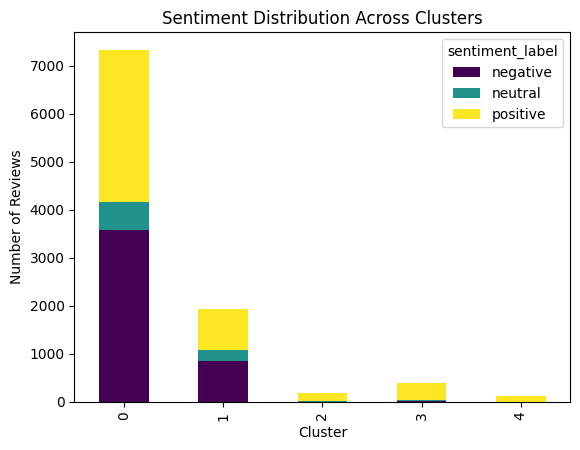

In [25]:
#Plot Distribtion of each sentiment per cluster
sentiment_distribution.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Sentiment Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Reviews')
plt.show()

In [26]:
#Find the most dominant sentiment for each cluster based on count
for cluster in sentiment_distribution.index:
    dominant_sentiment = sentiment_distribution.loc[cluster].idxmax()
    print(f"Cluster {cluster}: Dominant Sentiment is {dominant_sentiment}")

Cluster 0: Dominant Sentiment is negative
Cluster 1: Dominant Sentiment is positive
Cluster 2: Dominant Sentiment is positive
Cluster 3: Dominant Sentiment is positive
Cluster 4: Dominant Sentiment is positive


Although Cluster 0 says the dominant sentiment is negative and Cluster 1 is positive dominant, the counts show that they are almost even in terms of distribution between negative and positive sentiment. Let's remove foreign languages and see how it impacts our clusters.

### Sentiment Analysis 2

In [29]:
#Import Language dectection library
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

# Apply the function to detect language of each review
df['Language'] = df['review'].apply(detect_language)

In [30]:
df

,app_name,country_code,rating,review,sentiment_label,clean_review,cluster,Language
0,TikTok,us,5,محتوا جميل,positive,محتوا جميل,0,ar
1,TikTok,us,5,I love Ticktock !,positive,i love ticktock,3,sk
2,TikTok,us,1,Esli is on that platform n I don’t like her,negative,esli is on that platform n i don ’ t like her,0,en
3,TikTok,us,5,Entertaining and useful.,positive,entertaining and useful,0,en
4,TikTok,us,5,Me encantaaa 😻🥰,positive,me encantaaa 😻🥰,0,es
...,...,...,...,...,...,...,...,...
9945,WhatsApp,au,1,Keeps crashing and asking to restart phone,negative,keep crashing and asking to restart phone,0,en
9946,WhatsApp,au,2,I have been using Watts App for a number of ye...,negative,i have been using watt app for a number of yea...,0,en
9947,WhatsApp,au,1,Why is WhatsApp not on iPad yet? When is it co...,negative,why is whatsapp not on ipad yet when is it coming,0,en
9948,WhatsApp,au,2,No,negative,no,0,no


In [31]:
# Check for languages other then english
df.Language.value_counts()

Language
en         6331
fr         2060
es          197
unknown     141
so          121
af           79
no           73
de           71
it           66
ro           62
ca           61
ar           58
sl           52
id           49
ru           47
tl           41
nl           40
cy           37
et           36
pt           33
sw           29
fi           27
sk           26
vi           25
tr           21
sv           20
zh-cn        17
pl           16
da           16
hr           16
hu           15
lt           12
ko           10
sq           10
lv            7
uk            6
ur            5
th            4
bg            3
fa            3
mk            2
cs            2
ja            1
bn            1
zh-tw         1
Name: count, dtype: int64

In [34]:
# Create a copy of dataframe
df2 = df.copy()

In [35]:
# ilter out all foreign language reviews from dataframe
df2 = df2[df2['Language'] == 'en']

In [39]:
# Drop old cluster labels
df2.drop('cluster',axis=1,inplace=True)

In [51]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
new_X_kmeans = vectorizer.fit_transform(df2['clean_review']).toarray()

from sklearn.decomposition import PCA
# Reduce the dimensionality of the data into 3 components

pca = PCA(n_components=3) 
new_X_reduced = pca.fit_transform(new_X_kmeans)

In [56]:
# Applying KMeans clustering algorithm 
# Try 3 clusters
kmeans = KMeans(n_clusters=3, n_init=10, algorithm='elkan') 
df2['cluster'] = kmeans.fit_predict(new_X_reduced)

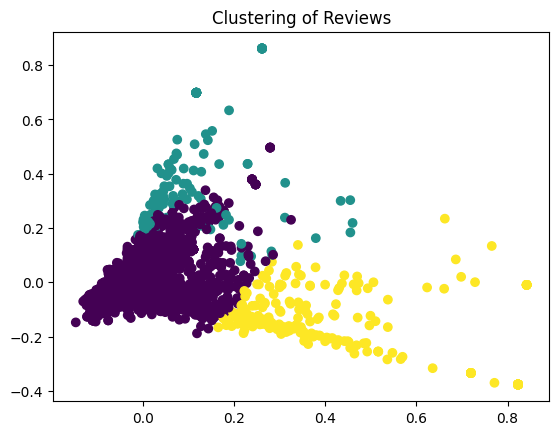

In [57]:
# Scatterplot of clustering in 2d
plt.scatter(new_X_reduced[:, 0], new_X_reduced[:, 1], c=df2['cluster'], cmap='viridis')
plt.title('Clustering of Reviews')
plt.show()

### Interpretation of Clusters 

In [58]:
# Step 1: Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
new_X_text = vectorizer.fit_transform(df2['clean_review'])

# Step 2: For each cluster, get the top 10 most common words
top_words_per_cluster = {}

for cluster_num in np.unique(df2['cluster']):
    # Filter reviews in the current cluster
    cluster_reviews = df2[df2['cluster'] == cluster_num]['clean_review']
    
    # Vectorize the reviews in the current cluster
    cluster_matrix = vectorizer.transform(cluster_reviews)
    
    # Sum up the occurrences of each word in the cluster
    word_counts = np.sum(cluster_matrix, axis=0)
    
    # Get the words corresponding to the indices
    word_freq = [(word, word_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    
    # Sort words by frequency and get the top 10
    top_words = sorted(word_freq, key=lambda x: x[1], reverse=True)[:10]
    
    # Store the top words in the dictionary
    top_words_per_cluster[cluster_num] = top_words

# Step 3: Display the top 10 words for each cluster
for cluster_num, top_words in top_words_per_cluster.items():
    print(f"Cluster {cluster_num}:")
    for word, freq in top_words:
        print(f"{word}: {freq}")
    print("\n")

Cluster 0:
app: 1937
account: 1046
like: 1023
video: 970
just: 874
people: 865
wa: 822
post: 803
don: 782
time: 780


Cluster 1:
great: 187
app: 57
love: 17
use: 12
platform: 11
video: 10
tiktok: 9
people: 9
content: 9
friend: 9


Cluster 2:
love: 329
youtube: 96
app: 72
video: 37
watch: 28
good: 27
like: 25
tiktok: 25
best: 18
just: 17




#### Cluster 0:
- Top Words: "app", "account", "like", "video", "just", "people", "wa", "post", "don", "time"
- Interpretation: This cluster seems to represent reviews where users are discussing issues or concerns, particularly related to accounts. The words "account," "just," "post," and "time" suggest that users might be frustrated with certain aspects of account management, posting, or the time taken for certain actions. Words like "don" and "wa" could be indicative of phrases like "don't" and "wasn't," which might imply negative sentiment or complaints. This cluster likely contains more critical or neutral feedback, where users are expressing concerns or frustrations with the app's functionality or user experience.
#### Cluster 1:
- Top Words: "great", "app", "love", "use", "platform", "video", "tiktok", "people", "content", "friend"
- Interpretation: This cluster seems to consist of positive reviews, focusing on the app's quality and usefulness. Words like "great," "love," "use," and "platform" suggest that users appreciate the app's overall functionality and its platform. The mention of "video," "content," and "friend" implies that users value the social and content-sharing aspects of the app, particularly with TikTok being mentioned. 
#### Cluster 2:
- Top Words:  "love", "youtube", "app", "video", "watch", "good", "like", "tiktok", "best", "just"
- Interpretation: This cluster represents highly positive reviews, where users express strong affection for the apps, particularly YouTube and TikTok. The words "love," "best," and "good" indicate a strong positive sentiment, with users particularly enjoying video content, as suggested by "video" and "watch.". This cluster reflects users who are highly satisfied and likely to recommend the app.

In [62]:
sentiment_distribution2 = df2.groupby(['cluster', 'sentiment_label']).size().unstack(fill_value=0)
print(sentiment_distribution)

sentiment_label  negative  neutral  positive
cluster                                     
0                    3232      549      2128
1                       6        3       158
2                       2        6       247


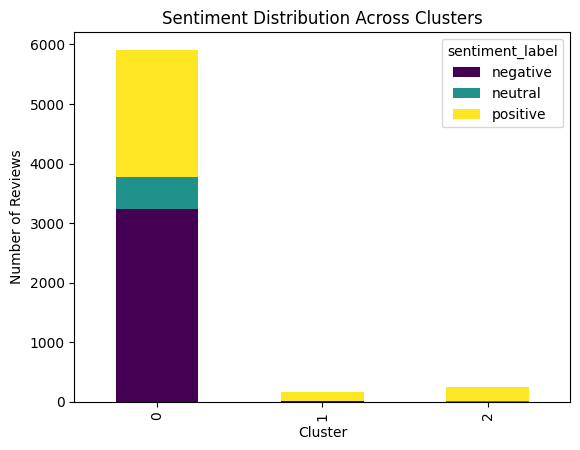

In [63]:
#Plot Distribtion of each sentiment per cluster
sentiment_distribution2.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Sentiment Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Reviews')
plt.show()